In [1]:
import rushd as rd
import pandas as pd
import numpy as np
import scipy.stats
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from textwrap import wrap
from statannotations.Annotator import Annotator

import warnings
warnings.filterwarnings("ignore",category=UserWarning)
warnings.filterwarnings("ignore",category=FutureWarning)

In [2]:
experimentdir1 = rd.datadir/'flow'/'2024.07.01_PMA_4dpi_14dpi'
experimentdir2 = rd.datadir/'flow'/'2024.07.22_PMA_4dpi_14dpi'
experimentdir3 = rd.datadir/'flow'/'2024.09.09_PMA_reprogramming'
experimentdir4 = rd.datadir/'flow'/'2024.11.04_PMA_reprogramming'

outputdir = rd.rootdir/'figures'/'PMA_reprogramming'

In [3]:
#rd.plot.plot_well_metadata(experimentdir4/'metadata.yaml')

# Load Data

In [4]:
data_columns = ['GFP-A'] # Only import these data columns for faster code

df1 = rd.flow.load_csv_with_metadata(data_path=experimentdir1/'csv_14dpi',yaml_path=experimentdir1/'metadata_14dpi.yaml',columns=data_columns)
df2 = rd.flow.load_csv_with_metadata(data_path=experimentdir2/'csv_14dpi',yaml_path=experimentdir2/'metadata_14dpi.yaml',columns=data_columns)
df3 = rd.flow.load_csv_with_metadata(data_path=experimentdir3/'csv',yaml_path=experimentdir3/'metadata.yaml',columns=data_columns)
df4 = rd.flow.load_csv_with_metadata(data_path=experimentdir4/'csv',yaml_path=experimentdir4/'metadata.yaml',columns=data_columns)


df1['rep'] = '2024.07.01'
df2['rep'] = '2024.07.22'
df3['rep'] = '2024.09.09'
df4['rep'] = '2024.11.04'


df1_mod = df1[df1['concentration'] != '200 nM'] # experimental mistake

df = pd.concat([df1_mod,df2,df3,df4])

df['condition'] = df['infection'] + ' ' + df['small molecule'] + ' ' + df['concentration']

Get rid of negative values

In [4]:
for i in np.arange(0,np.size(data_columns)):
    df = df.loc[df[data_columns[i]]>0]


# iMN gate

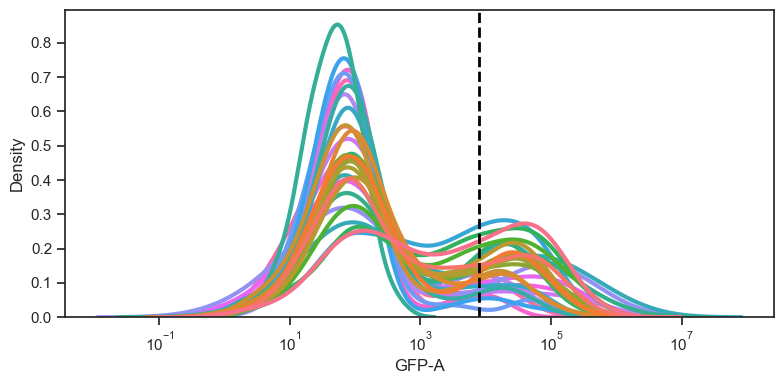

In [16]:
GFP_gate = 8 * 10**3 # Set gate at 8 * 10^3


# Plot gate
fig=plt.figure(figsize=(8,4))
g = sns.kdeplot(data=df.sample(10000),x='GFP-A',hue='condition',log_scale=True,common_norm=False,linewidth=3,legend=False)
plt.axvline(x=GFP_gate,linestyle='--',color='black',linewidth=2)
#fig.legend(bbox_to_anchor=(1, 1), loc='upper left', frameon=False)
fig.tight_layout()
plt.show()


# Make summary statistics dataframe

In [17]:
# Make a dataframe with summary statistics such as mean fluorescent intensity (MFI)
groups = ['rep','infection','small molecule','concentration','well']

summary_df = pd.concat([
    df.groupby(groups)['GFP-A'].apply(lambda x: np.mean(x > GFP_gate)*100).rename('(%) iMN\nof all cells'),
    df.groupby(groups)['GFP-A'].apply(lambda x: np.sum(x > GFP_gate)).rename('iMN Yield'),
    df.groupby(groups)['GFP-A'].apply(lambda x: np.sum(x > GFP_gate)/10000 * 100).rename('(%) iMN yield\nper MEF plated'),
    df.groupby(groups)['GFP-A'].apply(lambda x: np.size(x)).rename('Single Cells Count')
    ], axis=1)
summary_df = summary_df.reset_index()

# Statistics you would like to plot later
data2plot = ['(%) iMN yield\nper MEF plated','(%) iMN\nof all cells','Single Cells Count']

# Plotting Functions

In [18]:
def custom_barplot(x,y,data,filename,height=4,width=8,hue=None,xlabel_rot=90,xlabel='',plottitle='',palette='viridis',order=None,hue_order=None,pairs=None,alpha=0.8,reps=None):
    aspect = width / height
    g = sns.catplot(x=x,y=y,data=data,height=height,aspect=aspect,palette=palette,kind='bar',hue=hue,order=order,hue_order=hue_order,alpha=alpha,errorbar='ci',legend=None)
    ax = plt.gca()
    
    if order != None:
        #labels = [ '\n'.join(wrap(l, 4)) for l in order]
        labels = [ '\n'.join(l.split(' ')) for l in order]
    else:
        labels = None

    if hue == None:
        dodge = False
    elif hue != None:
        dodge = True

    if reps is None:
        g.map_dataframe(sns.stripplot, x=x,y=y, 
                    hue=hue, palette=["#404040"], 
                    alpha=0.8, dodge=dodge,order=order,hue_order=hue_order)
    
    marker_list = ['o', '^', 's', 'D', 'P', 'X']

    if reps is not None:
        for (j, rep) in enumerate(data[reps].unique()):
            sns.stripplot(
                ax=ax, data=data[data[reps] == rep],
                x=x, y=y,
                order=order,
                hue=hue,
                hue_order=hue_order,
                dodge=dodge, marker=marker_list[j],
                palette=['white'], size=5,
                edgecolor='black', linewidth=0.4,
                legend=None)

    if pairs != None:
        annotator = Annotator(ax,pairs,data=data,x=x,y=y,order=order,hue=hue,hue_order=hue_order)
        annotator.configure(test='t-test_ind',text_format='star',loc='inside', verbose=2)
        annotator.apply_and_annotate()
        #add_stat_annotation(ax, data=data, x=xcat, y=ycat, order=order,
        #            box_pairs=pairs,
        #            test='t-test_ind', text_format='star', verbose=2)

    ymin, ymax = ax.get_ylim()
    if ymax > 1000:
        k_formatter = matplotlib.ticker.FuncFormatter(lambda x, _: f'{x:.0f}' if abs(x) < 1000 else f'{x/1000:.0f}k')
        ax.yaxis.set_major_formatter(k_formatter)

    sns.despine(fig=None, ax=None, top=False, right=False, left=False, bottom=False, offset=None, trim=False) # make plot bounded on all sides
    
    g.set_xticklabels(labels,rotation=xlabel_rot, horizontalalignment='center' if xlabel_rot==0 else 'right')
    plt.xlabel(xlabel)
    plt.ylabel(y)
    plt.title(plottitle)

    if hue is not None:
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.0, frameon=False)  # Adjust bbox_to_anchor as needed

    plt.subplots_adjust(left=0.2, right=0.95, top=0.9, bottom=0.25) # make all plots have the same area
    #g.tight_layout()
    g.savefig(outputdir/str(filename + '.svg'),dpi=300)


# Plot Results

Formatting

In [19]:
sns.set_theme(style="ticks",font_scale=1)
savedict = {'(%) iMN yield\nper MEF plated':'(%) iMN yield per MEF plated',
            '(%) iMN\nof all cells':'(%) iMN of all cells',
            'Single Cells Count':'Single Cells Count'}

reps2plot = ['2024.07.01',
             '2024.07.22',
             '2024.09.09',
             '2024.11.04']
dataslice = summary_df[(summary_df['small molecule'].isin(["PMA", 'DMSO'])) & (summary_df['rep'].isin(reps2plot))]

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

NIL DD_0 nM vs. NIL DD_100 nM: t-test independent samples, P_val:1.107e-04 t=-4.694e+00
NIL_0 nM vs. NIL_100 nM: t-test independent samples, P_val:5.965e-03 t=-3.043e+00
NIL SNAP-DD_0 nM vs. NIL SNAP-DD_100 nM: t-test independent samples, P_val:1.461e-08 t=-8.210e+00
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

NIL DD_0 nM vs. NIL DD_100 nM: t-test independent samples, P_val:1.483e-03 t=-3.629e+00
NIL_0 nM vs. NIL_100 nM: t-test independent samples, P_val:7.355e-03 t=-2.953e+00
NIL SNAP-DD_0 nM vs. NIL SNAP-DD_100 nM: t-test independent samples, P_val:2.614e-07 t=-6.973e+00
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-

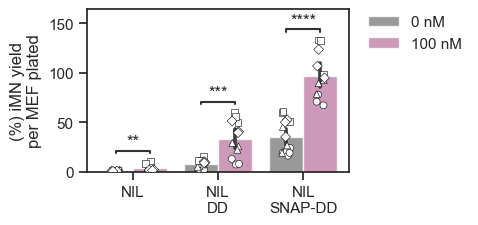

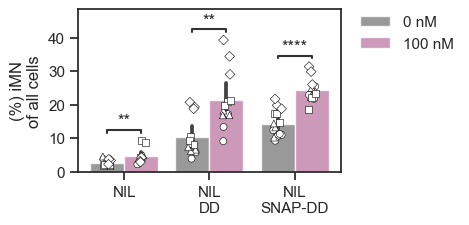

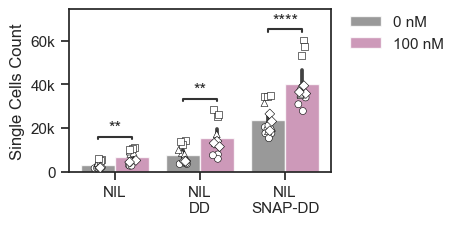

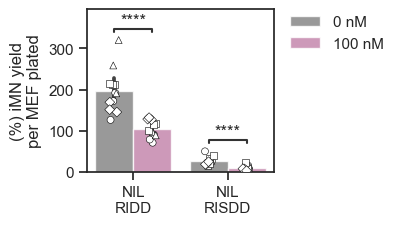

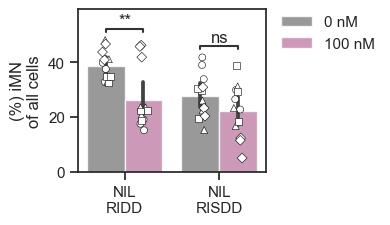

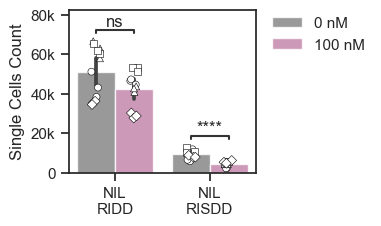

In [20]:
palette_PMA = {'0 nM':'grey','100 nM':'#cc75ab'}
data2plot = ['(%) iMN yield\nper MEF plated','(%) iMN\nof all cells','Single Cells Count']

order = ['NIL','NIL DD','NIL SNAP-DD']
pairs = [(('NIL', '0 nM'),('NIL','100 nM')),
          (('NIL DD', '0 nM'),('NIL DD','100 nM')),
          (('NIL SNAP-DD', '0 nM'),('NIL SNAP-DD','100 nM'))]

for i in data2plot:
    savetitle = '100nM_DD_' + savedict[i]
    custom_barplot('infection',i,dataslice,savetitle,
                    order = order,
                    hue = 'concentration',
                    hue_order=['0 nM','100 nM'],
                    palette=palette_PMA,
                    height=2.5,
                    width=3.5,
                    xlabel_rot=0,
                    alpha=0.8,
                    reps='rep',
                    pairs=pairs)


order = ['NIL RIDD','NIL RISDD']
pairs = [(('NIL RIDD', '0 nM'),('NIL RIDD','100 nM')),
          (('NIL RISDD', '0 nM'),('NIL RISDD','100 nM'))]

for i in data2plot:
    savetitle = '100nM_RAS_' + savedict[i]
    custom_barplot('infection',i,dataslice,savetitle,
                    order = order,
                    hue = 'concentration',
                    hue_order=['0 nM','100 nM'],
                    palette=palette_PMA,
                    height=2.5,
                    width=2.5,
                    xlabel_rot=0,
                    alpha=0.8,
                    reps='rep',
                    pairs=pairs)

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

NIL_0 nM vs. NIL_100 nM: t-test independent samples, P_val:5.965e-03 t=-3.043e+00
NIL DD_0 nM vs. NIL DD_100 nM: t-test independent samples, P_val:1.107e-04 t=-4.694e+00
NIL SNAP-DD_0 nM vs. NIL SNAP-DD_100 nM: t-test independent samples, P_val:1.461e-08 t=-8.210e+00
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

NIL_0 nM vs. NIL_100 nM: t-test independent samples, P_val:7.355e-03 t=-2.953e+00
NIL DD_0 nM vs. NIL DD_100 nM: t-test independent samples, P_val:1.483e-03 t=-3.629e+00
NIL SNAP-DD_0 nM vs. NIL SNAP-DD_100 nM: t-test independent samples, P_val:2.614e-07 t=-6.973e+00
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-

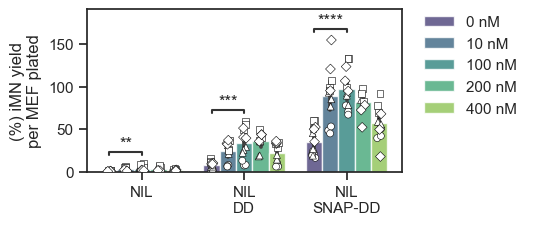

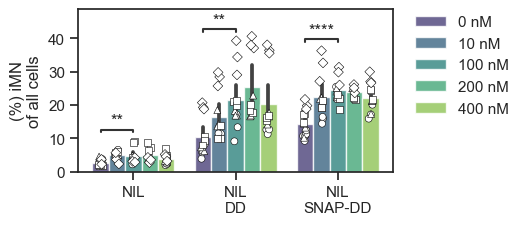

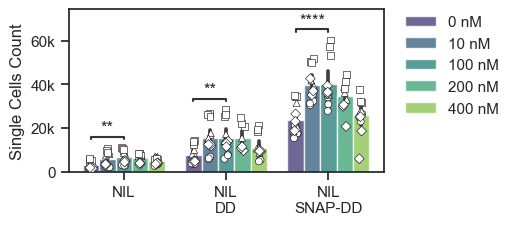

In [21]:
data2plot = ['(%) iMN yield\nper MEF plated','(%) iMN\nof all cells','Single Cells Count']


pairs = [(('NIL', '0 nM'),('NIL','100 nM')),
          (('NIL DD', '0 nM'),('NIL DD','100 nM')),
          (('NIL SNAP-DD', '0 nM'),('NIL SNAP-DD','100 nM'))]

order = ['NIL','NIL DD','NIL SNAP-DD']
hue_order = ['0 nM', '10 nM', '100 nM','200 nM', '400 nM']
for i in data2plot:
    savetitle = 'PMA_DD_' + savedict[i]
    custom_barplot('infection',i,dataslice,
                    savetitle,
                    hue='concentration',
                    hue_order=hue_order,
                    order = order,
                    palette="viridis",
                    height=2.5,
                    width=4.2,
                    xlabel_rot=0,
                    alpha=0.8,
                    reps='rep',
                    pairs=pairs
        )

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

NIL RIDD_0 nM vs. NIL RIDD_100 nM: t-test independent samples, P_val:1.054e-05 t=5.672e+00
NIL RISDD_0 nM vs. NIL RISDD_100 nM: t-test independent samples, P_val:7.752e-05 t=4.841e+00
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

NIL RIDD_0 nM vs. NIL RIDD_100 nM: t-test independent samples, P_val:2.413e-03 t=3.427e+00
NIL RISDD_0 nM vs. NIL RISDD_100 nM: t-test independent samples, P_val:1.442e-01 t=1.514e+00
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

NIL RIDD_0 nM vs. NIL RIDD_100 nM: t-test independent samples, P_val:7.067e-02 t=1.900e+0

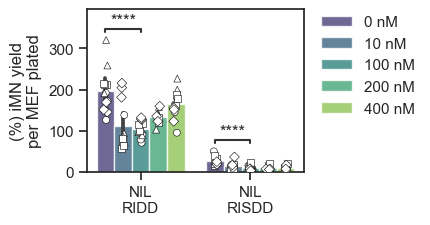

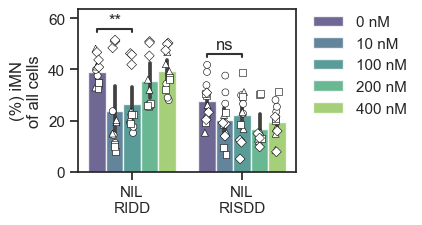

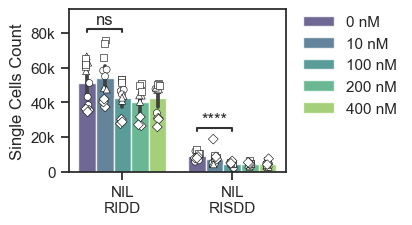

In [22]:
data2plot = ['(%) iMN yield\nper MEF plated','(%) iMN\nof all cells','Single Cells Count']

pairs = [(('NIL RIDD', '0 nM'),('NIL RIDD','100 nM')),
          (('NIL RISDD', '0 nM'),('NIL RISDD','100 nM'))]

order = ['NIL RIDD','NIL RISDD']
hue_order = ['0 nM', '10 nM', '100 nM','200 nM', '400 nM']
for i in data2plot:
    savetitle = 'PMA_RAS_' + savedict[i]
    custom_barplot('infection',i,dataslice,
                    savetitle,
                    hue='concentration',
                    hue_order=hue_order,
                    order = order,
                    palette="viridis",
                    height=2.5,
                    width=2.9,
                    xlabel_rot=0,
                    alpha=0.8,
                    reps='rep',
                    pairs=pairs
        )

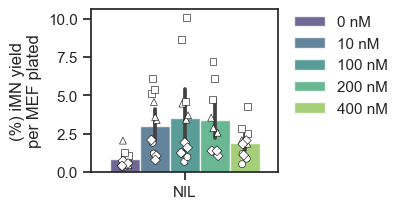

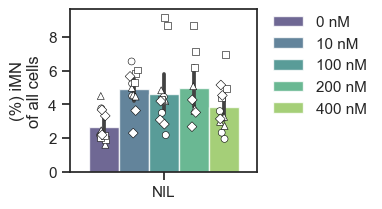

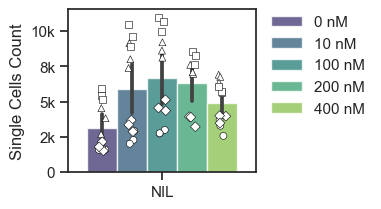

In [23]:
data2plot = ['(%) iMN yield\nper MEF plated','(%) iMN\nof all cells','Single Cells Count']

order = ['NIL']
hue_order = ['0 nM', '10 nM', '100 nM','200 nM', '400 nM']
for i in data2plot:
    savetitle = 'PMA_NIL-Only_' + savedict[i]
    custom_barplot('infection',i,dataslice[dataslice['infection'].isin(order)],
                    savetitle,
                    hue='concentration',
                    hue_order=hue_order,
                    order = order,
                    palette="viridis",
                    height=2.5,
                    width=2.5,
                    xlabel_rot=0,
                    alpha=0.8,
                    reps='rep'
        )

# Calculate Fold Changes from 0 nM

In [24]:
dataslice

slice = dataslice.drop(columns=['well','rep','small molecule'])

# Find the mean and standard error of the mean (SEM) for all technical and biological replicates in a given condition:
means = slice.groupby(['infection','concentration']).mean()
means.reset_index(drop=False,inplace=True) # Remove index

for infection_val in means['infection'].unique():
    norm_row = means[(means.infection == infection_val) & (means.concentration == '0 nM')]

    means.loc[(means['infection'] == infection_val),'Yield Fold Change'] = means.loc[
                    (means['infection'] == infection_val),'(%) iMN yield\nper MEF plated'] / norm_row['(%) iMN yield\nper MEF plated'].values[0]
    
    means.loc[(means['infection'] == infection_val),'Purity Fold Change'] = means.loc[
                    (means['infection'] == infection_val),'(%) iMN\nof all cells'] / norm_row['(%) iMN\nof all cells'].values[0]

#display(means[means.concentration == '100 nM'])

display(means)

,infection,concentration,(%) iMN\nof all cells,iMN Yield,(%) iMN yield\nper MEF plated,Single Cells Count,Yield Fold Change,Purity Fold Change
0,NIL,0 nM,2.654168,80.833333,0.808333,3142.250000,1.000000,1.000000
1,NIL,10 nM,4.926165,300.416667,3.004167,5890.250000,3.716495,1.856011
2,NIL,100 nM,4.644643,354.166667,3.541667,6677.916667,4.381443,1.749943
3,NIL,200 nM,4.996208,341.777778,3.417778,6343.777778,4.228179,1.882401
4,NIL,400 nM,3.829160,191.500000,1.915000,4868.333333,2.369072,1.442697
5,NIL DD,0 nM,10.352724,747.916667,7.479167,7670.500000,1.000000,1.000000
6,NIL DD,10 nM,16.382481,2393.833333,23.938333,15250.500000,3.200669,1.582432
7,NIL DD,100 nM,21.339905,3336.250000,33.362500,15316.666667,4.460724,2.061284
8,NIL DD,200 nM,25.348551,3574.333333,35.743333,15187.555556,4.779053,2.448491
9,NIL DD,400 nM,20.259692,2206.250000,22.062500,11024.666667,2.949861,1.956943


# Plot DD and SNAP-DD for figure 1

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

NIL vs. NIL DD: t-test independent samples, P_val:1.787e-05 t=-5.450e+00
NIL DD vs. NIL SNAP-DD: t-test independent samples, P_val:1.021e-05 t=-5.503e+00
NIL vs. NIL SNAP-DD: t-test independent samples, P_val:2.316e-07 t=-7.023e+00
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

NIL vs. NIL DD: t-test independent samples, P_val:1.694e-04 t=-4.520e+00
NIL DD vs. NIL SNAP-DD: t-test independent samples, P_val:5.463e-02 t=-2.016e+00
NIL vs. NIL SNAP-DD: t-test independent samples, P_val:4.570e-10 t=-9.825e+00
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.0

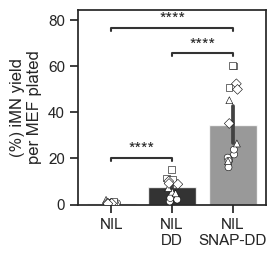

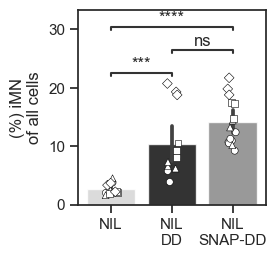

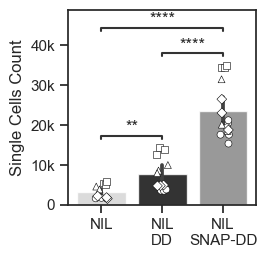

In [25]:
order = ['NIL','NIL DD','NIL SNAP-DD']
pairs = [('NIL','NIL DD'),
          ('NIL DD','NIL SNAP-DD'),
          ('NIL','NIL SNAP-DD')]

for i in data2plot:
    savetitle = 'DDvSDD_' + savedict[i]
    custom_barplot('infection',i,dataslice[dataslice.concentration == '0 nM'],savetitle,
                    order = order,
                    palette={'NIL':'lightgray','NIL DD':'black','NIL SNAP-DD':'grey'},
                    height=3,
                    width=2.5,
                    xlabel_rot=0,
                    alpha=0.8,
                    reps='rep',
                    pairs=pairs)
